# Labeled Faces In The Wild Deep Learning Classification


## Desription

The LFW (Labeled Faces In The Wild) dataset is composed of 5479 clases (different persons) for more than 13000 images.

## Initialization

In [179]:
# IMSIZE = [250, 250, 3]
DATASET_PATH = "../datasets/lfw_funneled"

## Load and split dataset

In [180]:
import tensorflow as tf

batch_size = 32
SEED = 123
w, h, l = 94, 125, 3
IMG_SHAPE = (h, w, l)

train_ds = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=SEED,
                                                       image_size=(h, w),
                                                       batch_size=batch_size,
                                                       label_mode='categorical')
val_ds = tf.keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                     validation_split=0.2,
                                                     subset="validation",
                                                     seed=SEED,
                                                     image_size=(h, w),
                                                     batch_size=batch_size,
                                                     label_mode='categorical')

class_names = train_ds.class_names
n_classes = len(class_names)

Found 4324 files belonging to 158 classes.
Using 3460 files for training.
Found 4324 files belonging to 158 classes.
Using 864 files for validation.


## Show images infos

In [181]:
print(class_names)
print(f"Image dimensions: {w}x{h}x{l}")
print(f"Number of classes: {n_classes}")

['Abdullah_Gul', 'Adrien_Brody', 'Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo', 'Andre_Agassi', 'Andy_Roddick', 'Angelina_Jolie', 'Ann_Veneman', 'Anna_Kournikova', 'Ari_Fleischer', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Bill_Gates', 'Bill_McBride', 'Bill_Simon', 'Britney_Spears', 'Carlos_Menem', 'Carlos_Moya', 'Catherine_Zeta-Jones', 'Charles_Moose', 'Colin_Powell', 'Condoleezza_Rice', 'David_Beckham', 'David_Nalbandian', 'Dick_Cheney', 'Dominique_de_Villepin', 'Donald_Rumsfeld', 'Edmund_Stoiber', 'Eduardo_Duhalde', 'Fidel_Castro', 'George_HW_Bush', 'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Gonzalo_Sanchez_de_Lozada', 'Gordon_Brown', 'Gray_Davis', 'Guillermo_Coria', 'Halle_Berry', 'Hamid_Karzai', 'Hans_Blix', 'Harrison_Ford', 'Hillary_Clinton', 'Howard_Dean', 'Hu_Jintao', 'Hugo_Chavez', 'Ian_Thorpe', 'Igor_Ivanov', 'Jack_Straw', 'Jackie_Chan', 'Jacques_Chirac', 'Jacques_Rogge', 'James_Blake',

## Show images

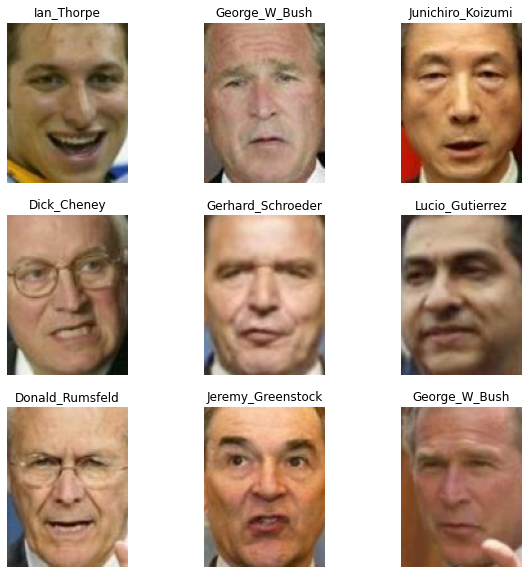

In [182]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [183]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(val_ds))

Number of validation batches: 109
Number of test batches: 27


## Configure dataset performance

In [184]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [185]:
"""
tf.keras.layers.RandomCrop
tf.keras.layers.RandomFlip
tf.keras.layers.RandomTranslation
tf.keras.layers.RandomRotation
tf.keras.layers.RandomZoom
tf.keras.layers.RandomHeight
tf.keras.layers.RandomWidth
tf.keras.layers.RandomContrast
"""

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    # tf.keras.layers.RandomContrast(0.1)
])

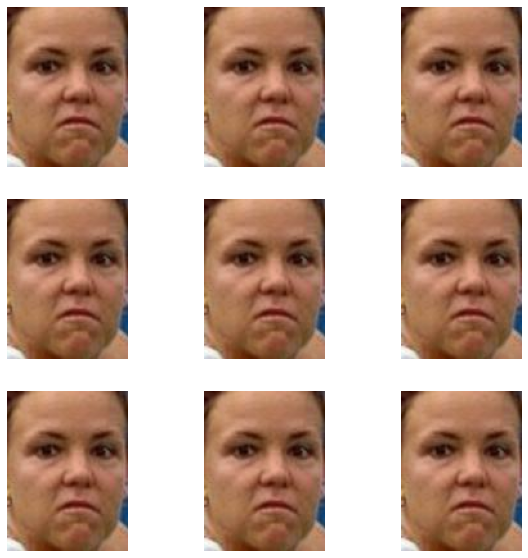

In [186]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
## Not displaying correctly in Jupyter for unknown reason

## Rescale pixel values

In [187]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Building model


In [188]:
from keras.optimizers import SGD
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications import ResNet50
import tensorflow as tf

# Change input shape to add image preprocessing
inputs = tf.keras.Input(shape=IMG_SHAPE)
y = preprocess_input(inputs)

# Create ResNet50 model
resnet = ResNet50(
    input_shape=[h, w, 3],
    weights="imagenet",
    include_top=False,
    classes=n_classes,
)
# Freeze layers for transfer learning
for layer in resnet.layers[: 10]:
    layer.trainable = False

# Add ResNet50 to the final model output
outputs = resnet(y)

# Change the ResNet50 output to be the number of class of the dataset
x = Flatten()(outputs)
x = Dense(n_classes, activation="softmax")(x)

# Assemble model
model = tf.keras.Model(inputs, x)

learning_rate = 0.001
nesterov = True
momentum = 0.9

opti = SGD(
    learning_rate=learning_rate,
    momentum=momentum,
    nesterov=nesterov,
)

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=opti, metrics=["accuracy"])
# model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opti, metrics=["accuracy"])
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 125, 94, 3)]      0         
                                                                 
 tf.__operators__.getitem_16  (None, 125, 94, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_16 (TFOpLamb  (None, 125, 94, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 4, 3, 2048)        23587712  
                                                                 
 flatten_15 (Flatten)        (None, 24576)             0         
                                                                 
 dense_13 (Dense)            (None, 158)               388

## Training

In [189]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", patience=2)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=[early_stop]
                    )

Epoch 1/50
109/109 [==============================] - 15s 97ms/step - loss: 3.3466 - accuracy: 0.3908 - val_loss: 3.9584 - val_accuracy: 0.2975
Epoch 2/50
109/109 [==============================] - 10s 92ms/step - loss: 0.5021 - accuracy: 0.8829 - val_loss: 1.6018 - val_accuracy: 0.6262
Epoch 3/50
109/109 [==============================] - 11s 97ms/step - loss: 0.0411 - accuracy: 0.9934 - val_loss: 1.2544 - val_accuracy: 0.6968
Epoch 4/50
109/109 [==============================] - 11s 103ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 1.2460 - val_accuracy: 0.7083
Epoch 5/50
109/109 [==============================] - 11s 102ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.2224 - val_accuracy: 0.7164
Epoch 6/50
109/109 [==============================] - 11s 103ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 1.2193 - val_accuracy: 0.7072
Epoch 7/50
109/109 [==============================] - 11s 102ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1929 - val_accur

## Save model

In [190]:
model.save_weights("../weights/resnet50_lfw.h5")


## Learning curvres

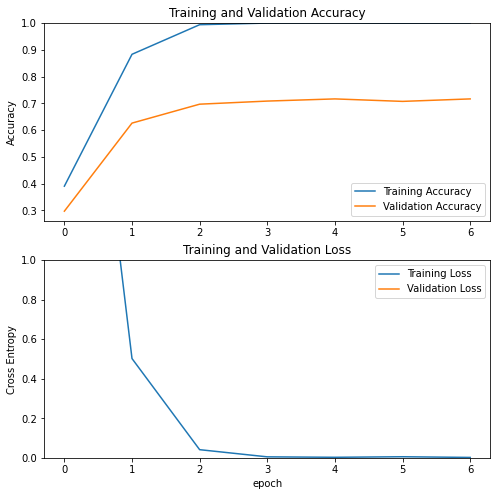

In [191]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Predict images

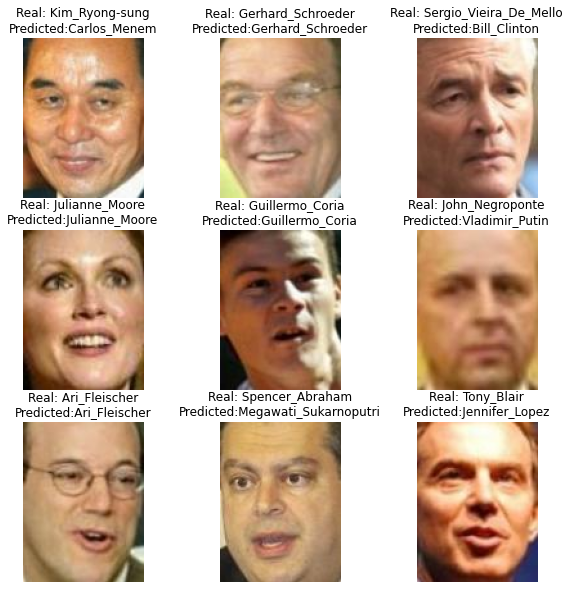

In [193]:
import numpy as np

image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Real: {class_names[np.argmax(label_batch[i])]}\nPredicted:{class_names[np.argmax(predictions[i])]}")
    plt.axis("off")